In [1]:
import pandas as pd
import numpy as np
import scipy.optimize
from autograd import jacobian
import matplotlib.pyplot as plt
import warnings
import random
warnings.filterwarnings(action='ignore')

Generate random numbers 𝛼 ∈ (0,1) and 𝛽 ∈ (0,1). Furthermore, generate the noisy data, according to the specific rule. Approximate the data by the following linear and rational functions.¶

In [2]:
alpha, beta = np.random.random(), np.random.random()
noise = np.random.normal(0, 1, 100)
epsilon = 0.001

x_k = np.arange(0, 1, 0.01)
y_k = [alpha * x_k[k] + beta + noise[k] for k in range(len(x_k))]

In [3]:
def lin_func(x, a, b):
    return a * x + b

def rational_func(x, a, b):
    return a / (1 + b * x)

In [4]:
def mse_func(x, func):
    sum = 0
    for i in range(100):
        sum += (func(x_k[i], x[0], x[1]) - y_k[i]) ** 2
    
    return sum

In [5]:
def grad_desc(func, args):
    return scipy.optimize.minimize(func, x0=(0,0), method='BFGS', tol=epsilon, args=(args,))

def conj_grad_desc(func, args):
    return scipy.optimize.minimize(func, x0=(0,0), method='CG', tol=epsilon, args=(args,))
     
def newt_method(func, args):
    return scipy.optimize.minimize(func, x0=(0,0), method='Newton-CG', jac=jacobian(func), tol=epsilon, args=(args,))

def lev_marq_alg(func, x, y):
    return scipy.optimize.curve_fit(func, xdata=x, ydata=y, method='lm')

## Linear approximant

In [6]:
grad_desc_res_lin = grad_desc(mse_func, lin_func).x
conj_grad_desc_res_lin = conj_grad_desc(mse_func, lin_func).x
newt_method_res_lin = newt_method(mse_func, lin_func).x
lev_marq_res_lin = lev_marq_alg(lin_func, x_k, y_k)[0]

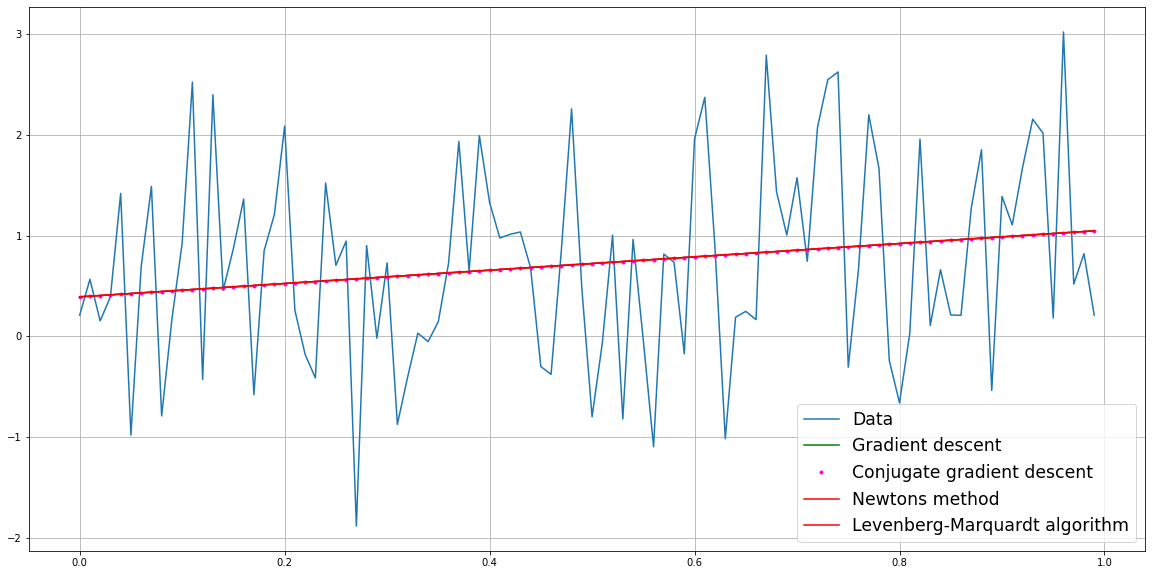

In [7]:
plt.figure(figsize=(20, 10))
plt.plot(x_k, y_k, label='Data')
plt.grid()

y = [lin_func(x, grad_desc_res_lin[0], grad_desc_res_lin[1]) for x in x_k]
plt.plot(x_k, y, label='Gradient descent', color='g')

y = [lin_func(x, conj_grad_desc_res_lin[0], conj_grad_desc_res_lin[1]) for x in x_k]
plt.plot(x_k, y, '.', label='Conjugate gradient descent', color='magenta')

y = [lin_func(x, newt_method_res_lin[0], newt_method_res_lin[1]) for x in x_k]
plt.plot(x_k, y, label='Newtons method', color='r')

y = [lin_func(x, lev_marq_res_lin[0], lev_marq_res_lin[1]) for x in x_k]
plt.plot(x_k, y, label='Levenberg-Marquardt algorithm', color='r')

plt.legend(fontsize='xx-large')
plt.savefig('linear_results.png', dpi=300)

In [8]:
def grad_desc_for_table(func, args):
    gd = scipy.optimize.minimize(func, x0=(0,0), method='BFGS', tol=epsilon, args=(args,))
    return gd.nit, gd.nfev, gd.x[0], gd.x[1]

def conj_grad_desc_for_table(func, args):
    cgd = scipy.optimize.minimize(func, x0=(0,0), method='CG', tol=epsilon, args=(args,))
    return cgd.nit, cgd.nfev, cgd.x[0], cgd.x[1]
     
def newt_method_for_table(func, args):
    nm = scipy.optimize.minimize(func, x0=(0,0), method='Newton-CG', jac=jacobian(func), tol=epsilon, args=(args,))
    return nm.nit, nm.nfev, nm.x[0], nm.x[1]

def lev_marq_alg_for_table(func, x, y):
    lma = scipy.optimize.curve_fit(func, xdata=x, ydata=y, method='lm')
    popt, pcov, infodict, errmsg, ier = scipy.optimize.curve_fit(func, xdata=x, ydata=y, method='lm', full_output=True)
    lma_1 = infodict
    return lma_1['nfev'], lma[0][0], lma[0][1]

In [9]:
linear = pd.DataFrame(columns=['method', 'num_of_iterations', 'num_of_f(x)_calculations', 'a', 'b'])

In [10]:
num_iter_gd, num_f_culc_gd, culc_a_gd, culc_b_gd = grad_desc_for_table(mse_func, lin_func)
num_iter_cgd, num_f_culc_cgd, culc_a_cgd, culc_b_cgd = conj_grad_desc_for_table(mse_func, lin_func)
num_iter_nm, num_f_culc_nm, culc_a_nm, culc_b_nm = newt_method_for_table(mse_func, lin_func)
num_f_culc_lma, culc_a_lma, culc_b_lma = lev_marq_alg_for_table(lin_func, x_k, y_k)


linear = linear.append({'method' : 'Gradient Descent', 'num_of_iterations': num_iter_gd,
                        'num_of_f(x)_calculations': num_f_culc_gd, 
                        'a' : culc_a_gd, 'b' : culc_b_gd}, ignore_index=True)

linear = linear.append({'method' : 'Conjugate Gradient Descent', 'num_of_iterations': num_iter_cgd,
                        'num_of_f(x)_calculations': num_f_culc_cgd, 
                        'a' : culc_a_cgd, 'b' : culc_b_cgd}, ignore_index=True)

linear = linear.append({'method' : 'Newton’s method', 'num_of_iterations': num_iter_nm,
                        'num_of_f(x)_calculations': num_f_culc_nm, 
                        'a' : culc_a_nm, 'b' : culc_b_nm}, ignore_index=True)

linear = linear.append({'method' : 'Levenberg-Marquardt algorithm', 'num_of_iterations': num_f_culc_lma//2,
                        'num_of_f(x)_calculations': num_f_culc_lma, 
                        'a' : culc_a_lma, 'b' : culc_b_lma}, ignore_index=True)

linear

,method,num_of_iterations,num_of_f(x)_calculations,a,b
0,Gradient Descent,4,18,0.661678,0.39271
1,Conjugate Gradient Descent,2,15,0.661678,0.39271
2,Newton’s method,3,32,0.661678,0.39271
3,Levenberg-Marquardt algorithm,3,7,0.661678,0.39271


## Rational approximant

In [11]:
grad_desc_res_rational = grad_desc(mse_func, rational_func).x
conj_grad_desc_res_rational = conj_grad_desc(mse_func, rational_func).x
newt_method_res_rational = newt_method(mse_func, rational_func).x
lev_marq_res_rational = lev_marq_alg(rational_func, x_k, y_k)[0]

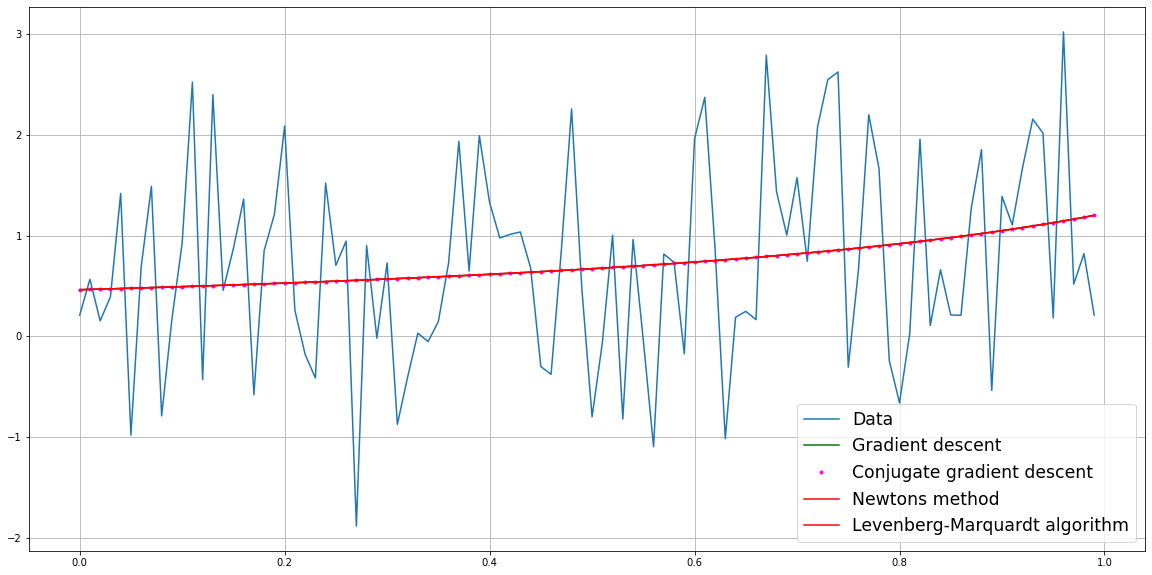

In [12]:
plt.figure(figsize=(20, 10))
plt.plot(x_k, y_k, label='Data')
plt.grid()

y = [rational_func(x, grad_desc_res_rational[0], grad_desc_res_rational[1]) for x in x_k]
plt.plot(x_k, y, label='Gradient descent', color='g')

y = [rational_func(x, conj_grad_desc_res_rational[0], conj_grad_desc_res_rational[1]) for x in x_k]
plt.plot(x_k, y, '.', label='Conjugate gradient descent', color='magenta')

y = [rational_func(x, newt_method_res_rational[0], newt_method_res_rational[1]) for x in x_k]
plt.plot(x_k, y, label='Newtons method', color='r')

y = [rational_func(x, lev_marq_res_rational[0], lev_marq_res_rational[1]) for x in x_k]
plt.plot(x_k, y, label='Levenberg-Marquardt algorithm', color='r')

plt.legend(fontsize='xx-large')
plt.savefig('rational_results.png', dpi=300)

In [13]:
rational = pd.DataFrame(columns=['method', 'num_of_iterations', 'num_of_f(x)_calculations', 'a', 'b'])

In [14]:
num_iter_gd, num_f_culc_gd, culc_a_gd, culc_b_gd = grad_desc_for_table(mse_func, rational_func)
num_iter_cgd, num_f_culc_cgd, culc_a_cgd, culc_b_cgd = conj_grad_desc_for_table(mse_func, rational_func)
num_iter_nm, num_f_culc_nm, culc_a_nm, culc_b_nm = newt_method_for_table(mse_func, rational_func)
num_f_culc_lma, culc_a_lma, culc_b_lma = lev_marq_alg_for_table(rational_func, x_k, y_k)


rational = rational.append({'method' : 'Gradient Descent', 'num_of_iterations': num_iter_gd,
                        'num_of_f(x)_calculations': num_f_culc_gd, 
                        'a' : culc_a_gd, 'b' : culc_b_gd}, ignore_index=True)

rational = rational.append({'method' : 'Conjugate Gradient Descent', 'num_of_iterations': num_iter_cgd,
                        'num_of_f(x)_calculations': num_f_culc_cgd, 
                        'a' : culc_a_cgd, 'b' : culc_b_cgd}, ignore_index=True)

rational = rational.append({'method' : 'Newton’s method', 'num_of_iterations': num_iter_nm,
                        'num_of_f(x)_calculations': num_f_culc_nm, 
                        'a' : culc_a_nm, 'b' : culc_b_nm}, ignore_index=True)

rational = rational.append({'method' : 'Levenberg-Marquardt algorithm', 'num_of_iterations': num_f_culc_lma // 2,
                        'num_of_f(x)_calculations': num_f_culc_lma, 
                        'a' : culc_a_lma, 'b' : culc_b_lma}, ignore_index=True)

rational

,method,num_of_iterations,num_of_f(x)_calculations,a,b
0,Gradient Descent,8,51,0.46348,-0.620493
1,Conjugate Gradient Descent,10,69,0.463478,-0.620496
2,Newton’s method,9,12,0.463479,-0.620495
3,Levenberg-Marquardt algorithm,11,23,0.463479,-0.620495
